In [43]:
import deconV as dv
import scout

import os
import torch
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np
import scanpy as sc
import scout

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
indir = "../../data/benchmarks/data/3bulk/"

In [45]:
reference_file = os.path.join(indir, "reference.h5ad")
bulk_file = os.path.join(indir, "bulk_norm.txt")

true_df = pd.read_csv(os.path.join(indir, "proportions.csv"), sep=",", index_col=0)

sadata = sc.read_h5ad(reference_file)

print(sadata.obs.groupby("cell_type").size())

bulk_df = pd.read_table(bulk_file, index_col=0)

sc.pp.filter_cells(sadata, min_genes=200)
sc.pp.filter_genes(sadata, min_cells=3)
adata = dv.tl.combine(sadata, bulk_df)
del sadata
scout.tl.scale_log_center(adata, target_sum=None, exclude_highly_expressed=False)
scout.tl.calculate_qc_metrics(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset=True)

cell_type
MDA-MB-438    2000
MCF7           697
HF             325
dtype: int64
scRNA-seq data - cells: 3022, genes: 18635
bulk RNA-seq data - samples: 1, genes: 18635


/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


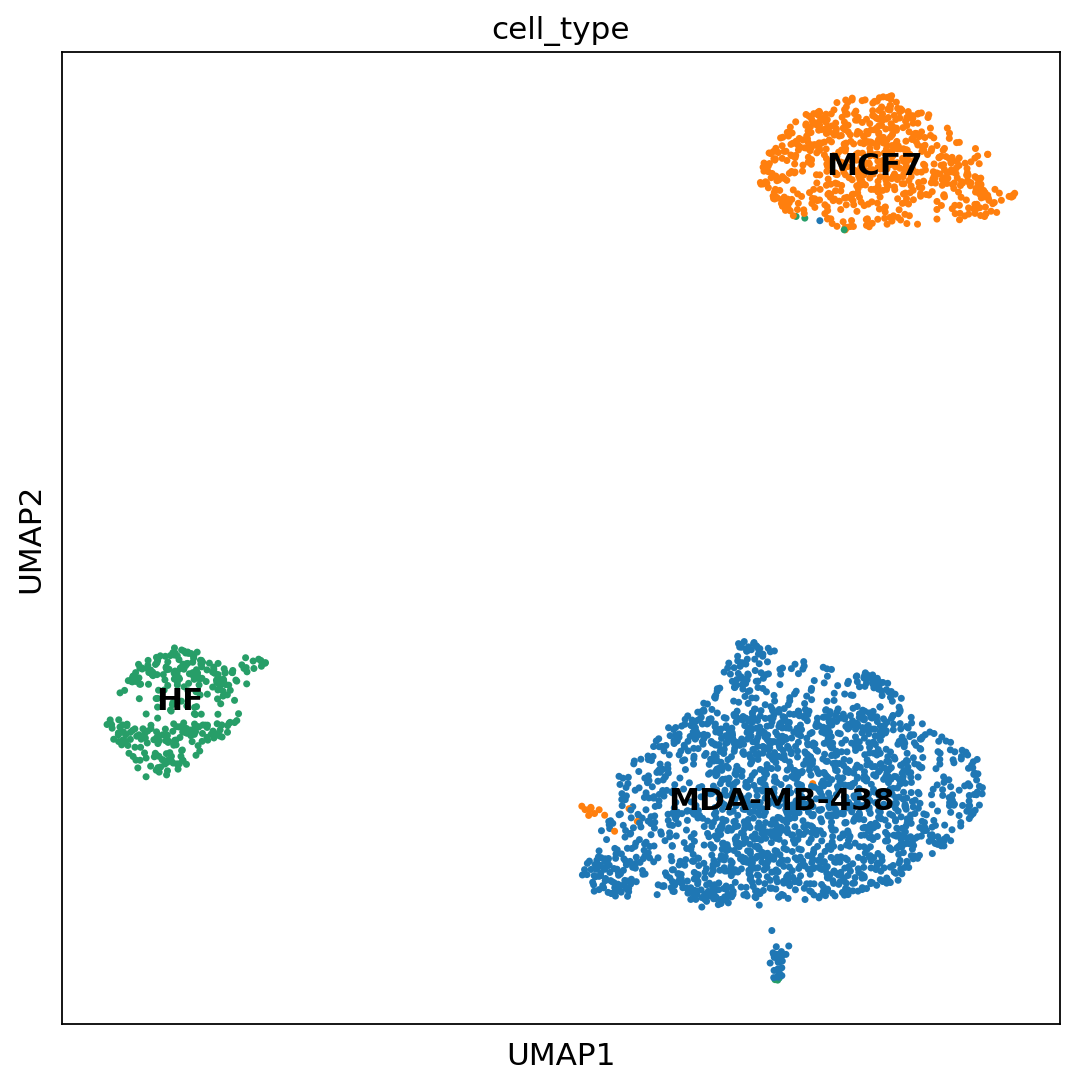

In [47]:
sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white')
sc.settings.figdir = "../deconV/figures/"
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["cell_type"], frameon=True, legend_loc="on data")#, save="_3_bulk.pdf", title="")

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [62]:
decon = dv.DeconV(
    adata, cell_type_key="cell_type",
    dropout_type="separate",
    model_type="gamma", sub_type_key=None,
    device=device
)

In [63]:
decon.fit_reference(num_epochs=2000, lr=0.1, lrd=0.999, layer="counts", fp_hack=True)

100%|██████████| 2000/2000 [02:49<00:00, 11.80it/s, loss=1.26e+04, lr=1.35e-02]


In [64]:
# decon.check_fit()

In [65]:
proportions = decon.deconvolute(model_dropout=True, lrd=0.999, lr=0.1, num_epochs=1000, progress=True)
proportions

100%|██████████| 1000/1000 [00:04<00:00, 239.63it/s, loss=4.81e+07, lr=3.68e-02]


tensor([[0.2954, 0.2225, 0.4821]], device='cuda:0', dtype=torch.float64)

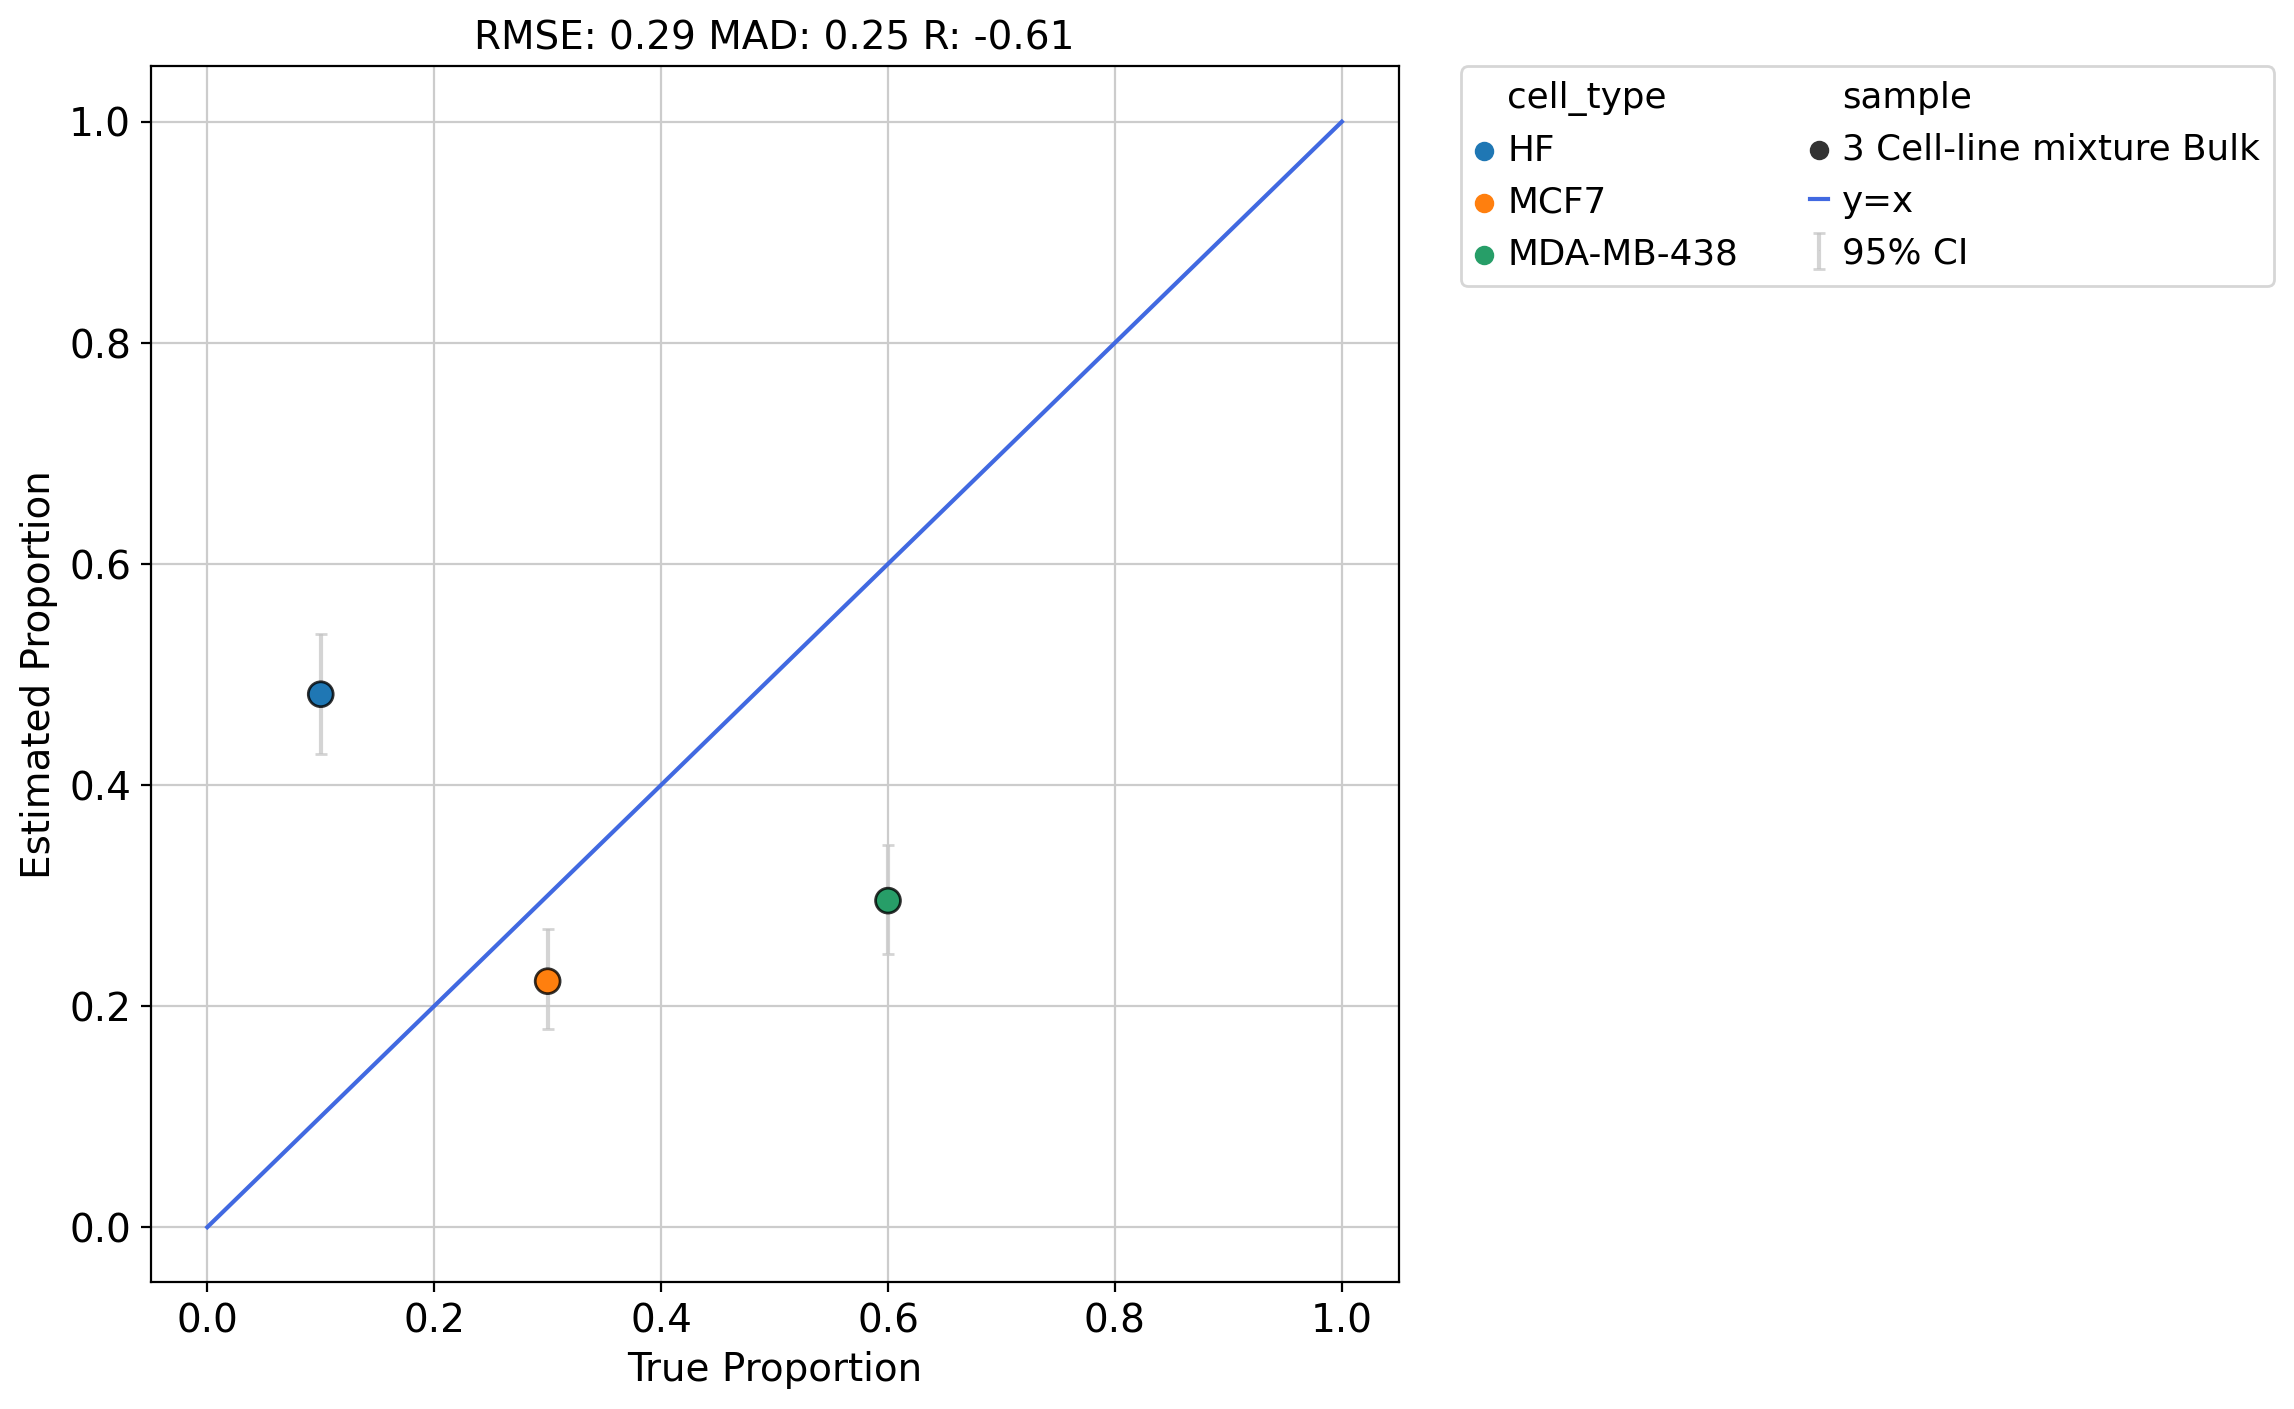

(0.28564887353691365, 0.25472932007055976, -0.6104201417110957)

In [66]:
res_df = decon.get_results_df().sort_values(["cell_type", "sample"])
res_df["true"] = true_df.reset_index().melt(id_vars="index").sort_values(["variable", "index"])["value"].values
dv.pl.xypredictions(res_df)